# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/grape/train",
    label_mode="categorical",
    class_names=['Grape Esca (Black_Measles)','Grape Leaf blight (Isariopsis_Leaf_Spot)','grape leaf Healthy','grape leaf black rot'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/grape/valid",
    label_mode="categorical",
    class_names=['Grape Esca (Black_Measles)','Grape Leaf blight (Isariopsis_Leaf_Spot)','grape leaf Healthy','grape leaf black rot'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 7335 files belonging to 4 classes.
==========================Validation Data====================
Found 1825 files belonging to 4 classes.


In [5]:
# All images will be rescaled by 1./255.and augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/grape/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/grape/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 7335 images belonging to 4 classes.
Found 1825 images belonging to 4 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Tue May 30 13:19:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P0               28W /  N/A|   5853MiB /  6144MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling With Augmentation

## DIY Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Grape_DIY_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DIY_model = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DIY_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model = DIY_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
367/367 [==============================] - ETA: 0s - loss: 0.6259 - accuracy: 0.7512
Epoch 1: val_accuracy improved from -inf to 0.78849, saving model to Grape_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


367/367 [==============================] - 110s 286ms/step - loss: 0.6259 - accuracy: 0.7512 - val_loss: 0.5565 - val_accuracy: 0.7885 - lr: 0.0010
Epoch 2/100
367/367 [==============================] - ETA: 0s - loss: 0.3209 - accuracy: 0.8894
Epoch 2: val_accuracy improved from 0.78849 to 0.79288, saving model to Grape_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


367/367 [==============================] - 61s 165ms/step - loss: 0.3209 - accuracy: 0.8894 - val_loss: 0.5479 - val_accuracy: 0.7929 - lr: 0.0010
Epoch 3/100
367/367 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.9115
Epoch 3: val_accuracy improved from 0.79288 to 0.79726, saving model to Grape_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


367/367 [==============================] - 58s 157ms/step - loss: 0.2471 - accuracy: 0.9115 - val_loss: 0.5398 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 4/100
367/367 [==============================] - ETA: 0s - loss: 0.1814 - accuracy: 0.9372
Epoch 4: val_accuracy improved from 0.79726 to 0.93425, saving model to Grape_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


367/367 [==============================] - 60s 162ms/step - loss: 0.1814 - accuracy: 0.9372 - val_loss: 0.1694 - val_accuracy: 0.9342 - lr: 0.0010
Epoch 5/100
367/367 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9425
Epoch 5: val_accuracy did not improve from 0.93425
367/367 [==============================] - 55s 150ms/step - loss: 0.1732 - accuracy: 0.9425 - val_loss: 0.2660 - val_accuracy: 0.9107 - lr: 0.0010
Epoch 6/100
367/367 [==============================] - ETA: 0s - loss: 0.1335 - accuracy: 0.9541
Epoch 6: val_accuracy did not improve from 0.93425
367/367 [==============================] - 55s 149ms/step - loss: 0.1335 - accuracy: 0.9541 - val_loss: 0.2884 - val_accuracy: 0.8942 - lr: 0.0010
Epoch 7/100
367/367 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9505
Epoch 7: val_accuracy improved from 0.93425 to 0.95616, saving model to Grape_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


367/367 [==============================] - 57s 156ms/step - loss: 0.1552 - accuracy: 0.9505 - val_loss: 0.1256 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 8/100
367/367 [==============================] - ETA: 0s - loss: 0.1335 - accuracy: 0.9566
Epoch 8: val_accuracy did not improve from 0.95616
367/367 [==============================] - 55s 149ms/step - loss: 0.1335 - accuracy: 0.9566 - val_loss: 0.2420 - val_accuracy: 0.9195 - lr: 0.0010
Epoch 9/100
367/367 [==============================] - ETA: 0s - loss: 0.0990 - accuracy: 0.9655
Epoch 9: val_accuracy improved from 0.95616 to 0.96986, saving model to Grape_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


367/367 [==============================] - 63s 171ms/step - loss: 0.0990 - accuracy: 0.9655 - val_loss: 0.0791 - val_accuracy: 0.9699 - lr: 0.0010
Epoch 10/100
367/367 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9663
Epoch 10: val_accuracy did not improve from 0.96986
367/367 [==============================] - 59s 160ms/step - loss: 0.0962 - accuracy: 0.9663 - val_loss: 0.0876 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 11/100
367/367 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.9704
Epoch 11: val_accuracy did not improve from 0.96986
367/367 [==============================] - 58s 157ms/step - loss: 0.0934 - accuracy: 0.9704 - val_loss: 0.1385 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 12/100
367/367 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9749
Epoch 12: val_accuracy improved from 0.96986 to 0.98027, saving model to Grape_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


367/367 [==============================] - 59s 162ms/step - loss: 0.0822 - accuracy: 0.9749 - val_loss: 0.0739 - val_accuracy: 0.9803 - lr: 0.0010
Epoch 13/100
367/367 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9748
Epoch 13: val_accuracy did not improve from 0.98027
367/367 [==============================] - 55s 148ms/step - loss: 0.0788 - accuracy: 0.9748 - val_loss: 0.1415 - val_accuracy: 0.9605 - lr: 0.0010
Epoch 14/100
367/367 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9749
Epoch 14: val_accuracy did not improve from 0.98027
367/367 [==============================] - 54s 146ms/step - loss: 0.0747 - accuracy: 0.9749 - val_loss: 0.3254 - val_accuracy: 0.9118 - lr: 0.0010
Epoch 15/100
367/367 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9785
Epoch 15: val_accuracy did not improve from 0.98027
367/367 [==============================] - 54s 148ms/step - loss: 0.0702 - accuracy: 0.9785 - val_loss: 0.090

INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


367/367 [==============================] - 59s 160ms/step - loss: 0.0365 - accuracy: 0.9875 - val_loss: 0.0549 - val_accuracy: 0.9825 - lr: 1.0000e-04
Epoch 19/100
367/367 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9891
Epoch 19: val_accuracy did not improve from 0.98247
367/367 [==============================] - 55s 148ms/step - loss: 0.0310 - accuracy: 0.9891 - val_loss: 0.0618 - val_accuracy: 0.9803 - lr: 1.0000e-04
Epoch 20/100
367/367 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9924
Epoch 20: val_accuracy did not improve from 0.98247
367/367 [==============================] - 54s 146ms/step - loss: 0.0252 - accuracy: 0.9924 - val_loss: 0.0682 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 21/100
367/367 [==============================] - ETA: 0s - loss: 0.0253 - accuracy: 0.9903
Epoch 21: val_accuracy did not improve from 0.98247
367/367 [==============================] - 54s 148ms/step - loss: 0.0253 - accuracy: 0.9903 - val

INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Augmented\assets


367/367 [==============================] - 59s 161ms/step - loss: 0.0176 - accuracy: 0.9950 - val_loss: 0.0486 - val_accuracy: 0.9830 - lr: 1.0000e-05
Epoch 34/100
367/367 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9940
Epoch 34: val_accuracy did not improve from 0.98301
367/367 [==============================] - 53s 145ms/step - loss: 0.0171 - accuracy: 0.9940 - val_loss: 0.0554 - val_accuracy: 0.9830 - lr: 1.0000e-05
Epoch 35/100
367/367 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9936
Epoch 35: val_accuracy did not improve from 0.98301
367/367 [==============================] - 54s 147ms/step - loss: 0.0176 - accuracy: 0.9936 - val_loss: 0.0632 - val_accuracy: 0.9797 - lr: 1.0000e-05
Epoch 36/100
367/367 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9940
Epoch 36: val_accuracy did not improve from 0.98301
367/367 [==============================] - 53s 145ms/step - loss: 0.0200 - accuracy: 0.9940 - val

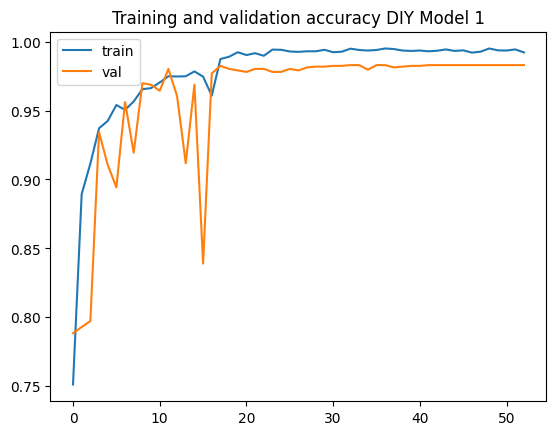

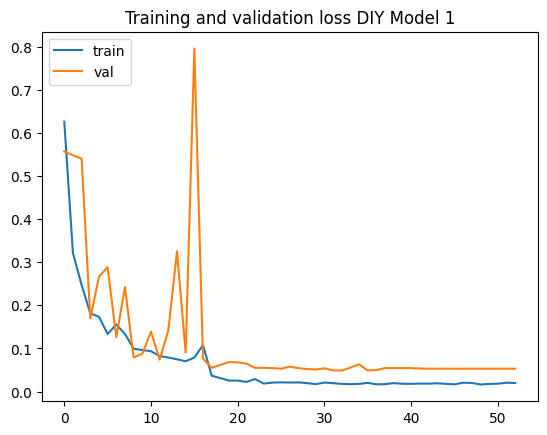

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model.history['accuracy' ]
val_acc  = history_DIY_model.history['val_accuracy' ]
loss     = history_DIY_model.history['loss' ]
val_loss = history_DIY_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model 1')
plt.legend(['train', 'val'], loc='upper left')

## DIY Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Grape_DIY_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DIY_model_2 = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DIY_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model_2 = DIY_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
367/367 [==============================] - ETA: 0s - loss: 0.8929 - accuracy: 0.6364
Epoch 1: val_accuracy improved from -inf to 0.80110, saving model to Grape_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Augmented\assets


367/367 [==============================] - 56s 150ms/step - loss: 0.8929 - accuracy: 0.6364 - val_loss: 0.5334 - val_accuracy: 0.8011 - lr: 0.0010
Epoch 2/100
367/367 [==============================] - ETA: 0s - loss: 0.4814 - accuracy: 0.8278
Epoch 2: val_accuracy did not improve from 0.80110
367/367 [==============================] - 52s 141ms/step - loss: 0.4814 - accuracy: 0.8278 - val_loss: 0.7566 - val_accuracy: 0.6964 - lr: 0.0010
Epoch 3/100
367/367 [==============================] - ETA: 0s - loss: 0.2943 - accuracy: 0.8871
Epoch 3: val_accuracy improved from 0.80110 to 0.90740, saving model to Grape_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Augmented\assets


367/367 [==============================] - 57s 156ms/step - loss: 0.2943 - accuracy: 0.8871 - val_loss: 0.2746 - val_accuracy: 0.9074 - lr: 0.0010
Epoch 4/100
367/367 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.9211
Epoch 4: val_accuracy improved from 0.90740 to 0.91178, saving model to Grape_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Augmented\assets


367/367 [==============================] - 58s 157ms/step - loss: 0.2209 - accuracy: 0.9211 - val_loss: 0.2220 - val_accuracy: 0.9118 - lr: 0.0010
Epoch 5/100
367/367 [==============================] - ETA: 0s - loss: 0.1854 - accuracy: 0.9331
Epoch 5: val_accuracy improved from 0.91178 to 0.95507, saving model to Grape_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Augmented\assets


367/367 [==============================] - 65s 176ms/step - loss: 0.1854 - accuracy: 0.9331 - val_loss: 0.1313 - val_accuracy: 0.9551 - lr: 0.0010
Epoch 6/100
367/367 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.9406
Epoch 6: val_accuracy did not improve from 0.95507
367/367 [==============================] - 61s 166ms/step - loss: 0.1803 - accuracy: 0.9406 - val_loss: 0.1495 - val_accuracy: 0.9447 - lr: 0.0010
Epoch 7/100
367/367 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.9526
Epoch 7: val_accuracy did not improve from 0.95507
367/367 [==============================] - 57s 154ms/step - loss: 0.1387 - accuracy: 0.9526 - val_loss: 0.2187 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 8/100
367/367 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9572
Epoch 8: val_accuracy improved from 0.95507 to 0.97260, saving model to Grape_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Augmented\assets


367/367 [==============================] - 63s 171ms/step - loss: 0.1255 - accuracy: 0.9572 - val_loss: 0.0898 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 9/100
367/367 [==============================] - ETA: 0s - loss: 0.1127 - accuracy: 0.9633
Epoch 9: val_accuracy improved from 0.97260 to 0.97534, saving model to Grape_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Augmented\assets


367/367 [==============================] - 69s 188ms/step - loss: 0.1127 - accuracy: 0.9633 - val_loss: 0.0959 - val_accuracy: 0.9753 - lr: 0.0010
Epoch 10/100
367/367 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9637
Epoch 10: val_accuracy improved from 0.97534 to 0.98740, saving model to Grape_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Augmented\assets


367/367 [==============================] - 73s 200ms/step - loss: 0.1119 - accuracy: 0.9637 - val_loss: 0.0502 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 11/100
367/367 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.9662
Epoch 11: val_accuracy did not improve from 0.98740
367/367 [==============================] - 57s 156ms/step - loss: 0.1007 - accuracy: 0.9662 - val_loss: 0.1494 - val_accuracy: 0.9545 - lr: 0.0010
Epoch 12/100
367/367 [==============================] - ETA: 0s - loss: 0.1121 - accuracy: 0.9674
Epoch 12: val_accuracy did not improve from 0.98740
367/367 [==============================] - 56s 154ms/step - loss: 0.1121 - accuracy: 0.9674 - val_loss: 0.3207 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 13/100
367/367 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9711
Epoch 13: val_accuracy did not improve from 0.98740
367/367 [==============================] - 57s 156ms/step - loss: 0.0924 - accuracy: 0.9711 - val_loss: 0.081

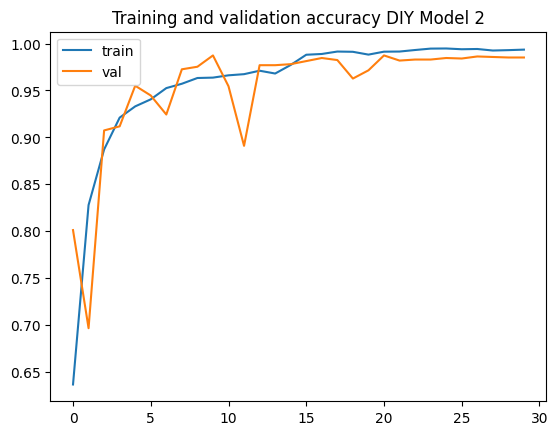

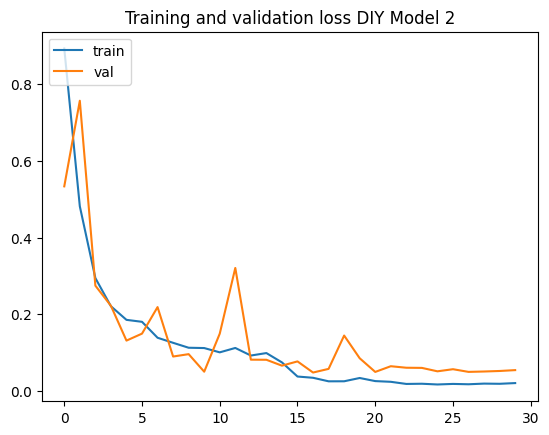

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model_2.history['accuracy' ]
val_acc  = history_DIY_model_2.history['val_accuracy' ]
loss     = history_DIY_model_2.history['loss' ]
val_loss = history_DIY_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model 2')
plt.legend(['train', 'val'], loc='upper left')